In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import sys
sys.path.append('/content/drive/MyDrive/Shortcut to courses materials/GitHub')

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.distributions as D

import numpy as np

from tqdm import tqdm

import matplotlib.pyplot as plt

from utils.plotting.two_dimensional import *
from utils.calculate_quantities import calculate_quantities
from utils.estimate_z_using_mc import estimate_z_using_mc

from hamiltonians.two_dimensional import NormalisedHarmonicPotential, HarmonicPotential, GMMPotential, DifficultGMMPotential
from kernels.overdamped_kernel import OverdampedKernel

from sis.sample import sample
from sis.protocols import InterpolationProtocol
from sis.protocols import LearnableInterpolationProtocol, LearnableProtocol, FullyLearnableProtocol
from sis.weight_calculators import AISLogWeightsCalculator


# Define the target and initial distribution


In [5]:
# Experimetn parameters
n_samples = 10000
n_steps = 200

device = "cuda"

In [6]:
#@title My Hamiltonians

from hamiltonians.base_hamiltonian import BaseHamiltonian


class Mypotential_1(BaseHamiltonian):
    def __init__(self, device='cpu'):
        super().__init__()
        self.device = device

        # Generate parameters for GMM components
        means = torch.tensor([[ 3.5766, -4.1628],
        [ 4.2073,  1.4487],
        [-4.4772,  6.0101],
        [ 0.0133,  4.4163],
        [-2.9068, -3.8240],
        [-6.8582, -0.7937],
        [ 4.4822,  6.4354],
        [ 0.5503,  0.0278],
        [-0.0090, -6.4072],
        [-3.5845,  0.2509],
        [ 6.3569, -0.3650]], device=device)
        stds = torch.tensor([[1.2248, 1.2875],
        [1.2985, 0.7862],
        [0.6037, 0.5242],
        [0.7117, 2.2801],
        [1.7568, 1.9775],
        [0.7350, 2.1029],
        [0.5596, 0.7311],
        [1.1928, 0.9394],
        [0.9130, 1.7394],
        [1.9990, 2.1033],
        [0.5877, 2.1133]], device=device)

        mixture_weights = torch.ones(11, device=self.device) / 11  # Equal weights for simplicity
        mixture_distribution = torch.distributions.Categorical(mixture_weights)
        component_distribution = torch.distributions.Independent(torch.distributions.Normal(means, stds), 1)
        self.p_0 = torch.distributions.MixtureSameFamily(mixture_distribution, component_distribution)

        self.is_normalized = True
        self.sampleable = True

    def H(self, x):
        return -self.p_0.log_prob(x) # Has Z = 1

    def sample(self, n_samples):
        return self.p_0.sample((n_samples,))

#################################################################
class Mypotential_2(BaseHamiltonian):
    def __init__(self, device='cpu'):
        super().__init__()
        self.device = device

        # Generate parameters for GMM components
        means = torch.tensor([[ 3.3291e+00, -3.8653e+00],
        [ 3.6562e+00,  1.2538e+00],
        [-4.4847e+00,  6.0047e+00],
        [-1.3149e-03,  4.4958e+00],
        [-2.6724e+00, -3.7133e+00],
        [-6.9983e+00, -2.2905e+00],
        [ 4.4782e+00,  6.4556e+00],
        [ 8.6704e-02,  2.2671e-02],
        [ 1.1690e-02, -7.0092e+00],
        [-4.9517e+00,  1.3482e+00],
        [ 6.3277e+00, -7.3722e-02]], device=device)
        stds = torch.tensor([[1.4032, 1.4319],
        [1.3028, 0.7862],
        [0.5125, 0.5190],
        [0.7318, 2.0554],
        [1.4169, 1.5620],
        [0.5145, 0.5279],
        [0.5420, 0.5101],
        [0.6231, 0.2908],
        [0.5282, 0.4847],
        [1.6961, 0.9092],
        [0.6066, 2.1681]], device=device)

        mixture_weights = torch.ones(11, device=self.device) / 11  # Equal weights for simplicity
        mixture_distribution = torch.distributions.Categorical(mixture_weights)
        component_distribution = torch.distributions.Independent(torch.distributions.Normal(means, stds), 1)
        self.p_0 = torch.distributions.MixtureSameFamily(mixture_distribution, component_distribution)

        self.is_normalized = True
        self.sampleable = True

    def H(self, x):
        return -self.p_0.log_prob(x) # Has Z = 1

    def sample(self, n_samples):
        return self.p_0.sample((n_samples,))

################################################################


## Description :
My Hamiltonian results on a Mixture of Gaussian distribution with eleven components (11). The goal was to model the shape of a **starfish**, with additional disk shapes between the tentacles.

## building process:

* The building process involved using the following function in polar coordinates to create the starfish shape, where 'a' and 'b' are parameters to adjust the shape:
\begin{align*} x_1 & =acos(\theta)+bsin(5\theta)cos(\theta) + noise \\x_2& =asin(\theta)+bsin(5\theta)sin(\theta) +noise \end{align*}

*  Then I filled the tentacle with scatter plot of ellipsoid shape.

* At the end of the day when a got the samples, a fit a mixture of gausians based on the samples using the **VAE** algorithm.

## why this particular case ?

I chose this one because of its potential complexity, which makes it suitable for this test.

In [7]:
# Define initial distribution (tractable)
f_0 = NormalisedHarmonicPotential(torch.tensor([0., 0.], device=device), torch.eye(2, device=device))

# Define target distribution (intractable)
# f_T = NormalisedHarmonicPotential(torch.tensor([0., 0.], device=device), torch.eye(2, device=device))
# f_T = HarmonicPotential(torch.tensor([3., 3.], device=device))
#f_T = GMMPotential(device=device)
#f_T = DifficultGMMPotential(device=device)
f_T=Mypotential_1(device=device)
beta = 1. # This is the inverse temperature of the target

# We use this for all experiments (for now)
AIS_forward_kernel = OverdampedKernel(beta, 0.01, device=device)
AIS_weights_calculator = AISLogWeightsCalculator()


Z is 0.9985097050666809


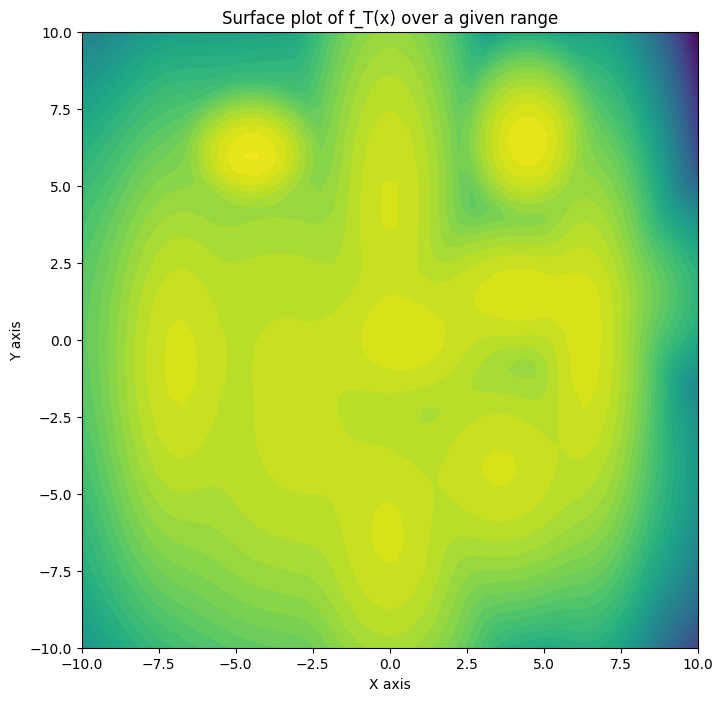

In [8]:
Z = estimate_z_using_mc(f_T, beta, [-10, -10], [20, 20], samples=10000000, device=device)
print('Z is %s' %(Z))
plot_f_T(f_T, -10, 10, device=device)

/content/drive/MyDrive/Shortcut to courses materials/GitHub/sis/protocols.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=self.device)


Average Work: -1.78
Variance of Work: 0.61
Normalizing Constant Estimate: 0.49
Variance of Normalizing Constant Estimate: 65.64


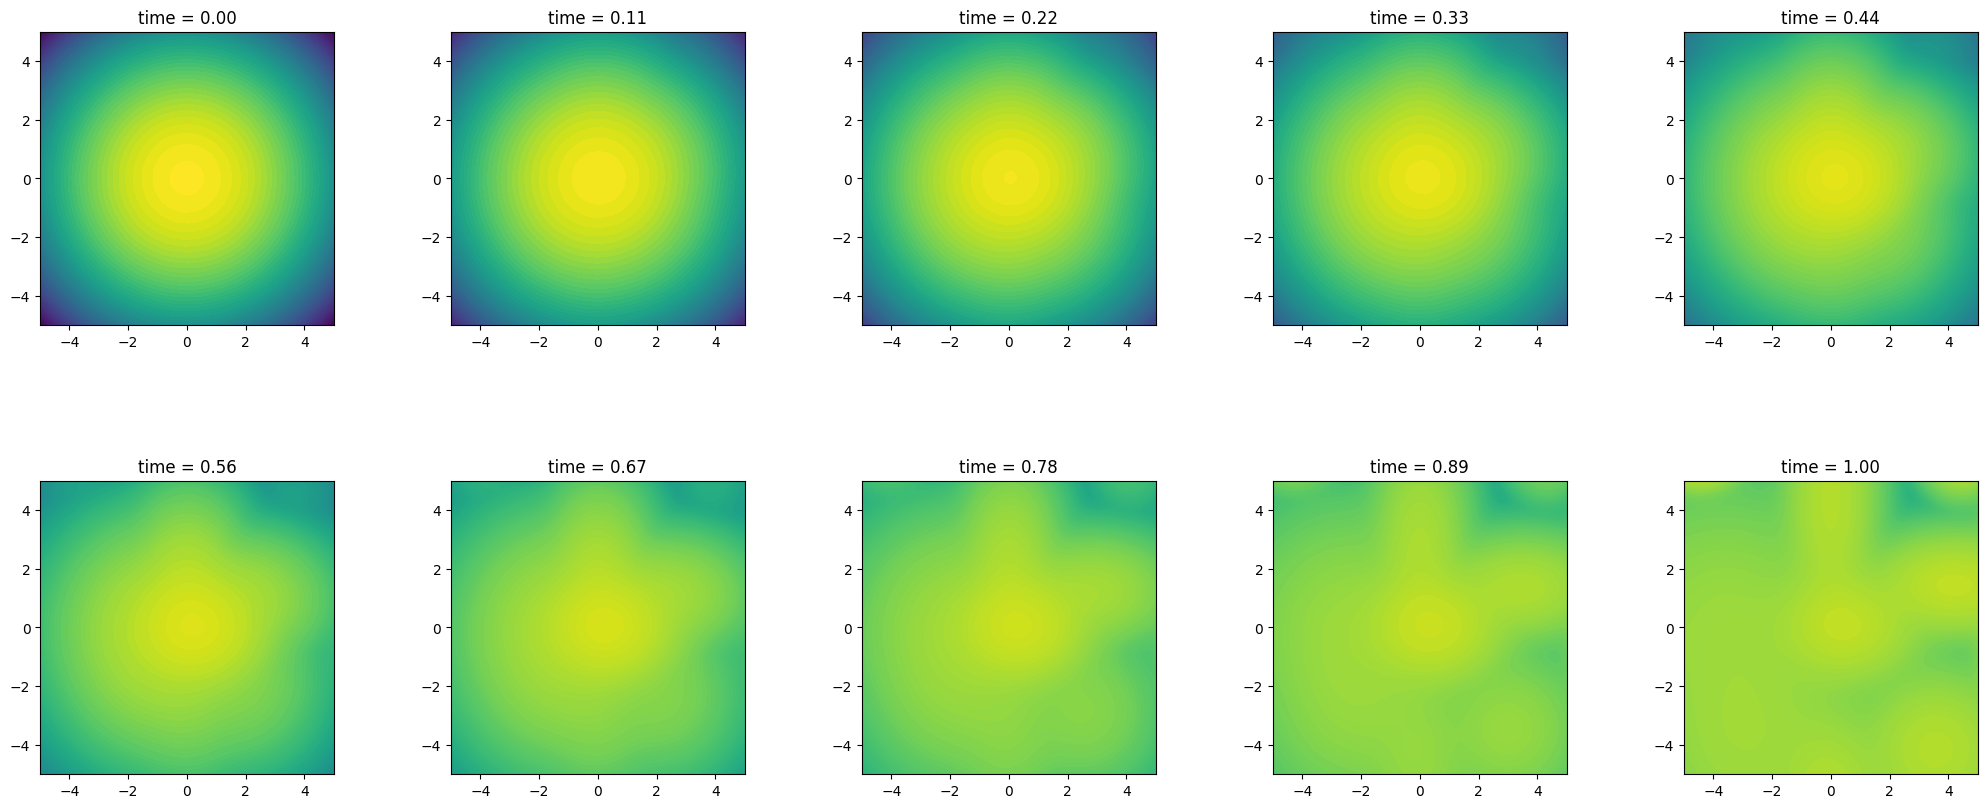

In [9]:
#Setup interpolation_protocol for comparison
interpolation_protocol = InterpolationProtocol(f_0, f_T, device)

AIS_history = sample(f_0, interpolation_protocol, AIS_forward_kernel, AIS_weights_calculator, n_samples, n_steps)

calculate_quantities(AIS_weights_calculator)
# plot_beta(interpolation_protocol)
plot_protocol(interpolation_protocol, beta, device=device)
# plot_animation(interpolation_protocol, AIS_history, device=device)

# Learnable Protocol

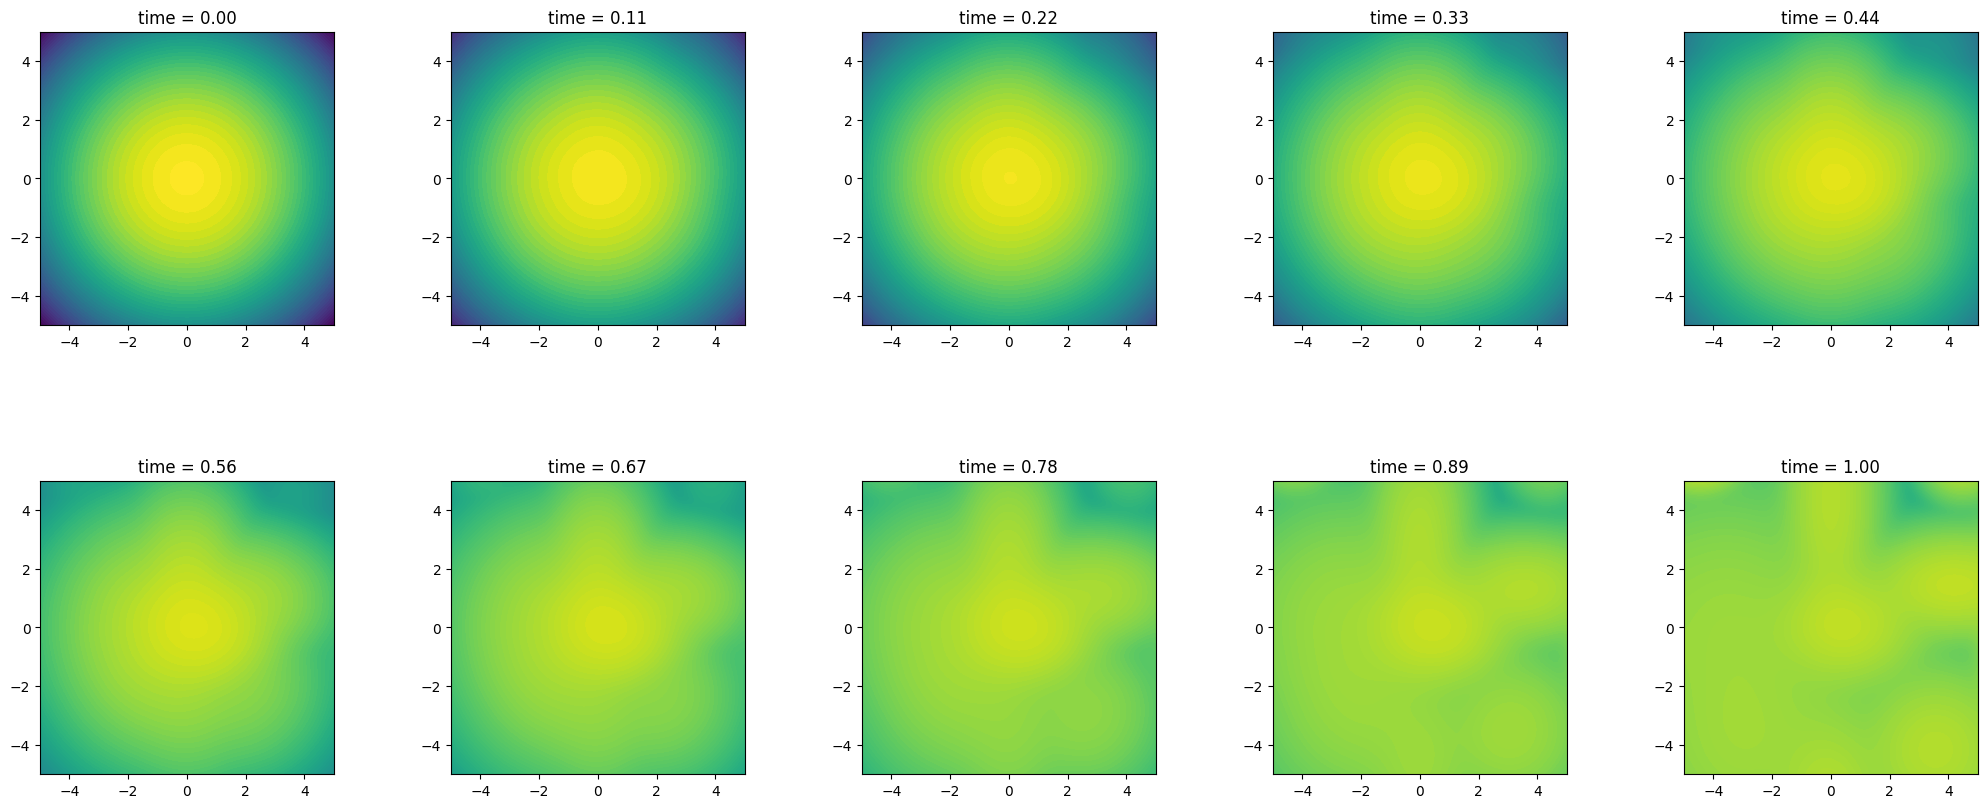

In [10]:
from sis.protocols import LearnableProtocol

# Try different numbers of layers
# Try different architectures
# Try differen time embeddings

class EBM(nn.Module):
    def __init__(self):
        super(EBM, self).__init__()
        self.EBM = nn.Sequential(
            nn.Linear(3, 32),  # Adjusted for an additional input dimension (time)
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64,64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def __call__(self, x, t):
        t_tensor = torch.full((x.shape[0], 1), fill_value=t, device=x.device, dtype=x.dtype)
        xt = torch.cat((x, t_tensor), dim=1)

        ebm_output = self.EBM(xt).view(-1) * 10
        return ebm_output


ebm = EBM()
# protocol = FullyLearnableProtocol(f_0, f_T, ebm)
protocol = LearnableProtocol(f_0, f_T, ebm)
# protocol = LearnableInterpolationProtocol(f_0, f_T, device=device)
protocol.to(device)
plot_protocol(protocol, beta, device=device)

In [ ]:
from sis.learn_protocol import learn_protocol

# Try different learning rates
# Try to fit as many samples on the GPU as possible (Don't change n_samples, we want this to be consisten)
# Try running it for longer≠≠≠

AIS_weights_calculator.reset()
learn_protocol(f_0, protocol, AIS_forward_kernel, AIS_weights_calculator, 3000, n_steps, 60, lr=0.001)

Z:0.69, loss:178.83: 100%|██████████| 60/60 [02:38<00:00,  2.65s/it]


Average Work: -1.77
Variance of Work: 0.62
Normalizing Constant Estimate: 0.60
Variance of Normalizing Constant Estimate: 185.33


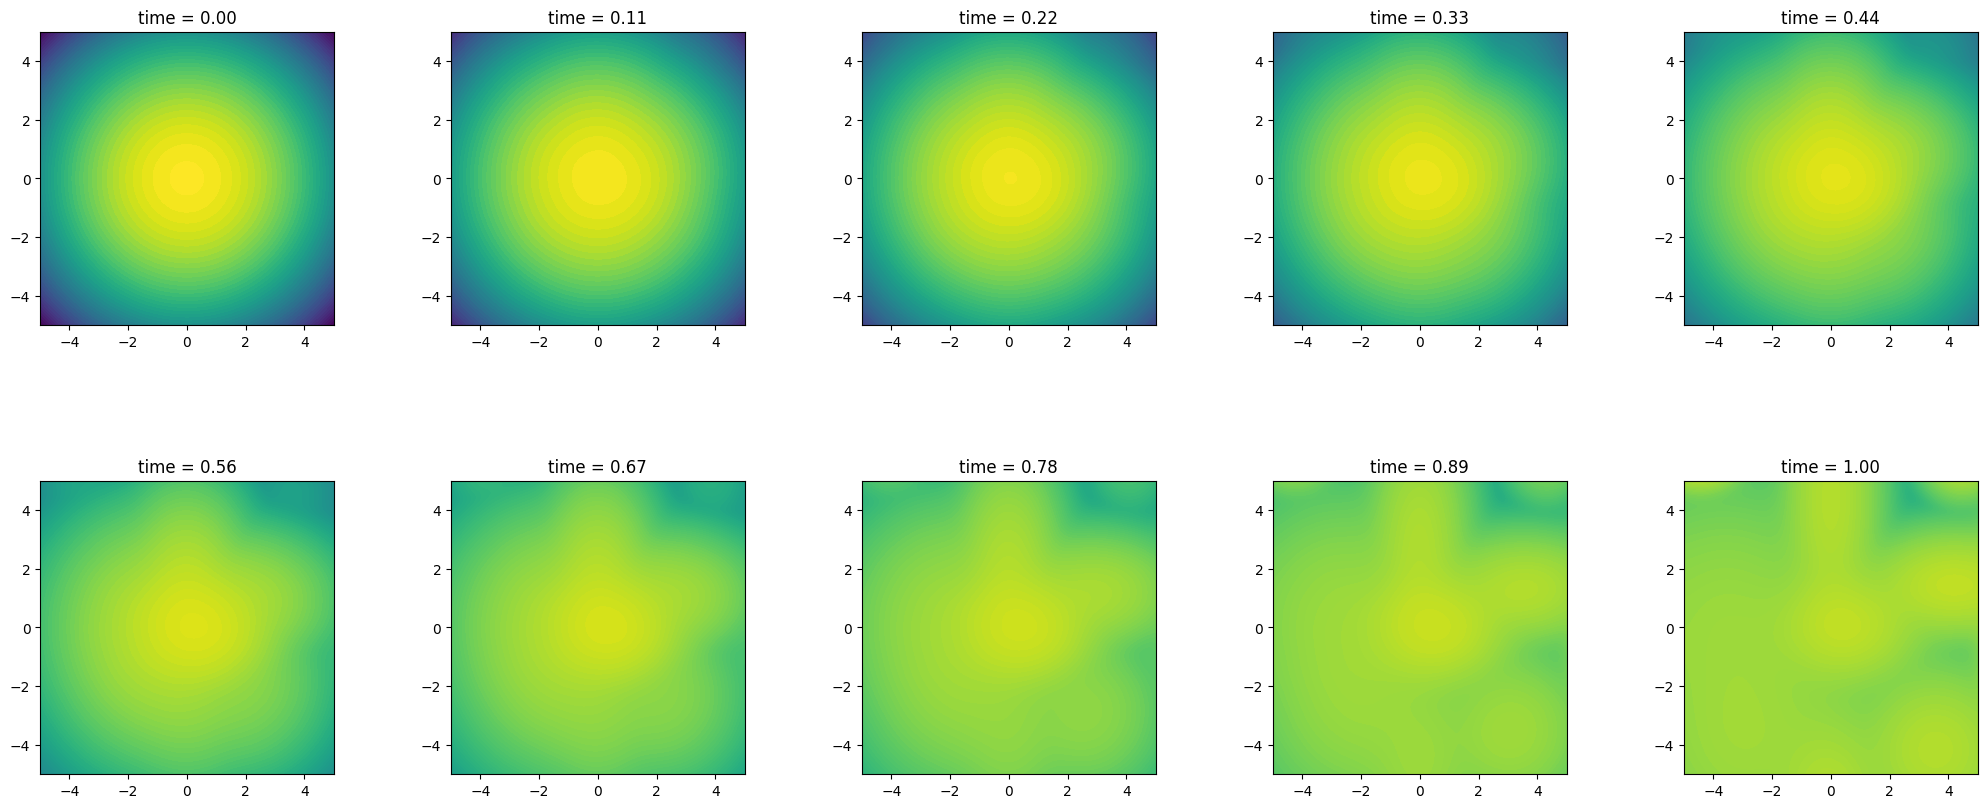

In [11]:
AIS_weights_calculator.reset()
full_history = sample(f_0, protocol, AIS_forward_kernel, AIS_weights_calculator, n_samples, n_steps)

calculate_quantities(AIS_weights_calculator)
# plot_beta(protocol, device=device)
plot_protocol(protocol, beta, device=device)
# plot_animation(protocol, full_history, device=device)

# Add extra eval / validation?